# Setup

In [ ]:
#|export
import pickle,gzip,math,os,time,shutil,torch,random,timm,torchvision,io,PIL
import fastcore.all as fc,matplotlib as mpl,numpy as np,matplotlib.pyplot as plt
from collections.abc import Mapping
from pathlib import Path
from operator import attrgetter,itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager

import torchvision.transforms.functional as TF,torch.nn.functional as F
from torchvision import transforms
from torch import tensor,nn,optim
from torch.utils.data import DataLoader,default_collate
from torch.nn import init
from torch.optim import lr_scheduler
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset,load_dataset_builder
from fastcore.foundation import L, store_attr

from miniai.datasets import *
from miniai.conv import *
from miniai.learner import *
from miniai.activations import *
from miniai.init import *
from miniai.sgd import *
from miniai.resnet import *

In [ ]:
face_url = "https://images.pexels.com/photos/2690323/pexels-photo-2690323.jpeg?w=256"
spiderweb_url = "https://images.pexels.com/photos/34225/spider-web-with-water-beads-network-dewdrop.jpg?w=256"

In [ ]:
# Setting device
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loading Images

In [ ]:
def download_image(url):
    imgb = fc.urlread(url, decode=False) 
    return torchvision.io.decode_image(tensor(list(imgb), dtype=torch.uint8)).float()/255.

content_im.shape: torch.Size([3, 256, 256])


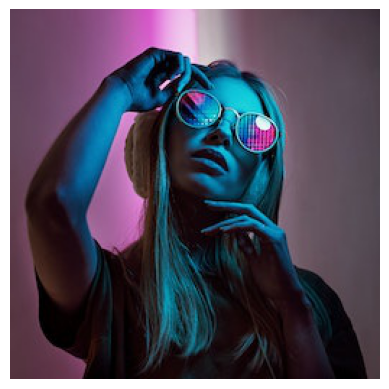

In [ ]:
content_im = download_image(face_url).to(def_device)
print('content_im.shape:', content_im.shape)
show_image(content_im);

In [ ]:
content_im.min(),content_im.max() # Check bounds

(tensor(0., device='cuda:0'), tensor(1., device='cuda:0'))

# Optimizing Images

In [ ]:
class LengthDataset():
    def __init__(self, length=1): self.length=length
    def __len__(self): return self.length
    def __getitem__(self, idx): return 0,0

def get_dummy_dls(length=100):
    return DataLoaders(DataLoader(LengthDataset(length), batch_size=1),
                       DataLoader(LengthDataset(1), batch_size=1))

In [ ]:
class TensorModel(nn.Module):
    def __init__(self, t):
        super().__init__()
        self.t = nn.Parameter(t.clone())
    def forward(self, x=0): return self.t

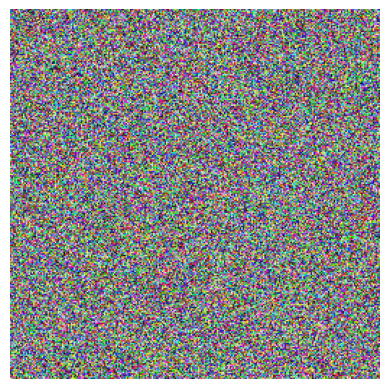

In [ ]:
model = TensorModel(torch.rand_like(content_im))
show_image(model());

In [ ]:
class ImageOptCB(TrainCB):
    def predict(self, learn): learn.preds = learn.model()
    def get_loss(self, learn): learn.loss = learn.loss_func(learn.preds)

In [ ]:
def loss_fn_mse(im):
    return F.mse_loss(im, content_im)

model = TensorModel(torch.rand_like(content_im))
cbs = [ImageOptCB(), ProgressCB(), MetricsCB(), DeviceCB()]
learn = Learner(model, get_dummy_dls(100), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1)

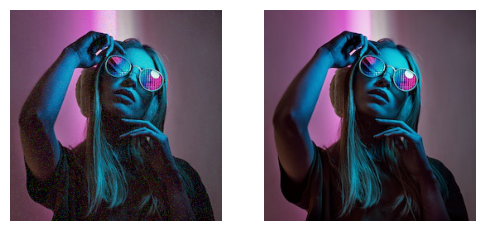

In [ ]:
show_images([learn.model().clip(0, 1), content_im]);

## Viewing progress

In [ ]:
class ImageLogCB(Callback):
    order = ProgressCB.order + 1
    def __init__(self, log_every=10): store_attr(); self.images=[]; self.i=0
    def after_batch(self, learn): 
        if self.i%self.log_every == 0: self.images.append(to_cpu(learn.preds.clip(0, 1)))
        self.i += 1
    def after_fit(self, learn): show_images(self.images)

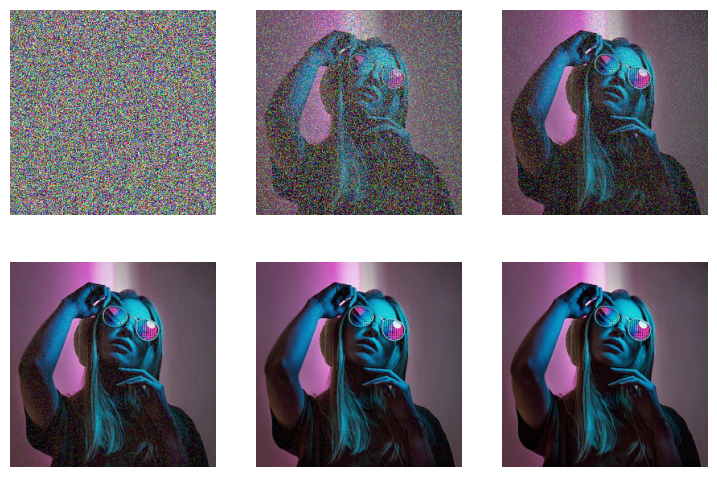

In [ ]:
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_fn_mse, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

## Getting Features from VGG16

### Load VGG network

![vgg diag](https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png)

In [ ]:
print(timm.list_models('*vgg*'))

['repvgg_a2', 'repvgg_b0', 'repvgg_b1', 'repvgg_b1g4', 'repvgg_b2', 'repvgg_b2g4', 'repvgg_b3', 'repvgg_b3g4', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


In [ ]:
vgg16 = timm.create_model('vgg16', pretrained=True).to(def_device).features

In [ ]:
#vgg16

### Normalize Images

In [ ]:
imagenet_mean = tensor([0.485, 0.456, 0.406])
imagenet_std = tensor([0.229, 0.224, 0.225])

In [ ]:
# Try 1 (won't work):
# (content_im - imagenet_mean) / imagenet_std

In [ ]:
imagenet_mean.shape

torch.Size([3])

In [ ]:
content_im.shape

torch.Size([3, 256, 256])

In [ ]:
imagenet_mean[:,None,None].shape

torch.Size([3, 1, 1])

In [ ]:
# Try 2:
def normalize(im):
    imagenet_mean = tensor([0.485, 0.456, 0.406])[:,None,None].to(im.device)
    imagenet_std = tensor([0.229, 0.224, 0.225])[:,None,None].to(im.device)
    return (im - imagenet_mean) / imagenet_std

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

In [ ]:
# And with torchvision transforms:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

In [ ]:
normalize(content_im).min(), normalize(content_im).max()

(tensor(-2.1179, device='cuda:0'), tensor(2.6400, device='cuda:0'))

### Get intermediate representations, take 1:

In [ ]:
def calc_features(imgs, target_layers=[18, 25]): 
    x = normalize(imgs)
    feats = []
    for i, layer in enumerate(vgg16[:max(target_layers)+1]):
        x = layer(x)
        if i in target_layers:
            feats.append(x.clone())
    return feats

In [ ]:
feats = calc_features(content_im)
[f.shape for f in feats]

[torch.Size([512, 32, 32]), torch.Size([512, 16, 16])]

In [ ]:
# Exercise: Can you do this using hooks?

### What's the point?

In [ ]:
# Show perceptual loss (maybe show some pics from distil.pub or something?)
# https://distill.pub/2017/feature-visualization/

# Optimizing an Image with Content Loss

In [ ]:
class ContentLossToTarget():
    def __init__(self, target_im, target_layers=[18, 25]):
        fc.store_attr()
        with torch.no_grad():
            self.target_features = calc_features(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_features(input_im, self.target_layers), self.target_features))

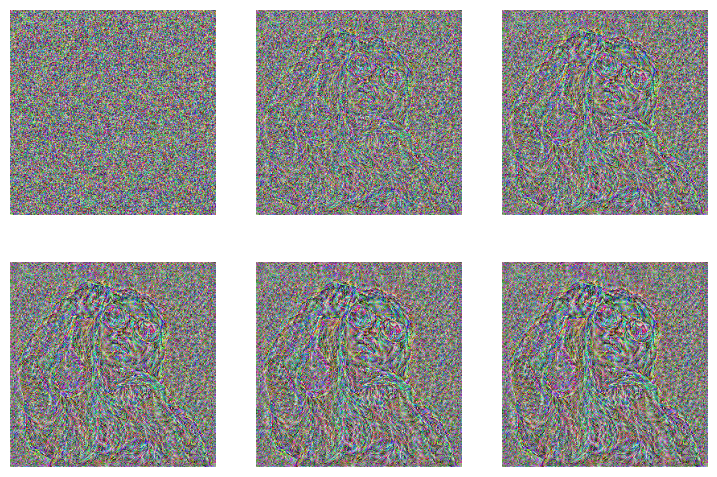

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im)
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

**Choosing the layers determines the kind of features that are important:**

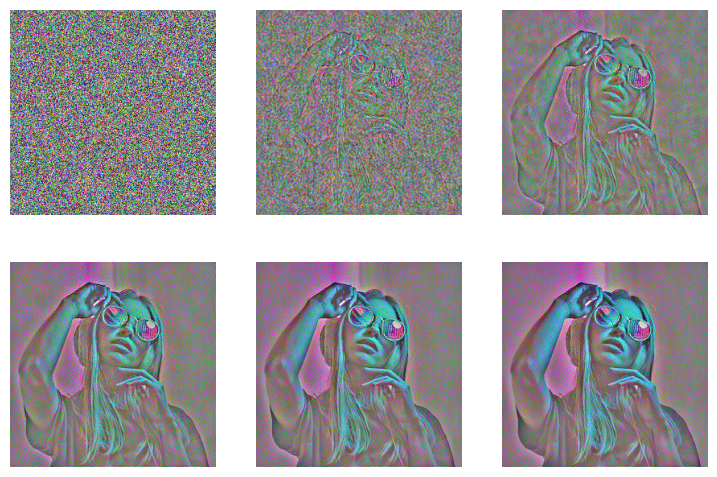

In [ ]:
loss_function_perceptual = ContentLossToTarget(content_im, target_layers=[1, 6])
model = TensorModel(torch.rand_like(content_im))
learn = Learner(model, get_dummy_dls(150), loss_function_perceptual, 
                lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(log_every=30)])

# Style Loss with Gram Matrix

So, we know how to extract feature maps... they still encode spatial info.

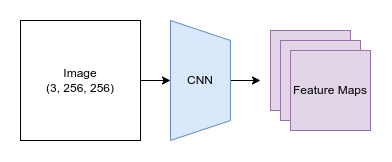

Gram matrix... 

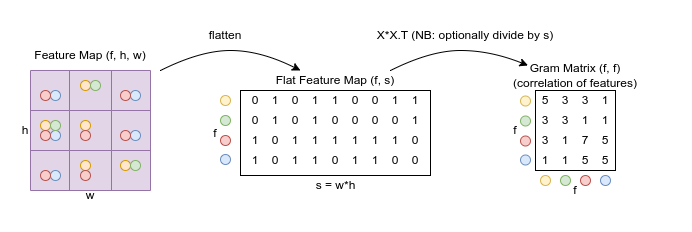

In [ ]:
# TODO try to explain gram matrices :)

In [ ]:
t = torch.tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 1, 0, 0]])
t

tensor([[0, 1, 0, 1, 1, 0, 0, 1, 1],
        [0, 1, 0, 1, 0, 0, 0, 0, 1],
        [1, 0, 1, 1, 1, 1, 1, 1, 0],
        [1, 0, 1, 1, 0, 1, 1, 0, 0]])

In [ ]:
torch.einsum('fs, gs -> fg', t, t)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

In [ ]:
t.matmul(t.T)

tensor([[5, 3, 3, 1],
        [3, 3, 1, 1],
        [3, 1, 7, 5],
        [1, 1, 5, 5]])

### Trying it out

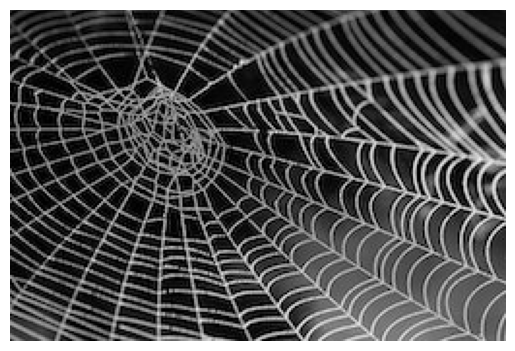

In [ ]:
style_im = download_image(spiderweb_url).to(def_device)
show_image(style_im);

In [ ]:
def calc_grams(img, target_layers=[1, 6, 11, 18, 25]):
    return L(torch.einsum('chw, dhw -> cd', x, x) / (x.shape[-2]*x.shape[-1]) # 'bchw, bdhw -> bcd' if batched
            for x in calc_features(img, target_layers))

In [ ]:
style_grams = calc_grams(style_im)

In [ ]:
[g.shape for g in style_grams] # The gram matrices for features from different layers

[torch.Size([64, 64]),
 torch.Size([128, 128]),
 torch.Size([256, 256]),
 torch.Size([512, 512]),
 torch.Size([512, 512])]

In [ ]:
style_grams.attrgot('shape')

(#5) [torch.Size([64, 64]),torch.Size([128, 128]),torch.Size([256, 256]),torch.Size([512, 512]),torch.Size([512, 512])]

In [ ]:
class StyleLossToTarget():
    def __init__(self, target_im, target_layers=[1, 6, 11, 18, 25]):
        fc.store_attr()
        with torch.no_grad(): self.target_grams = calc_grams(target_im, target_layers)
    def __call__(self, input_im): 
        return sum((f1-f2).pow(2).mean() for f1, f2 in 
               zip(calc_grams(input_im, self.target_layers), self.target_grams))

In [ ]:
style_loss = StyleLossToTarget(style_im)

In [ ]:
style_loss(content_im)

tensor(501.6082, device='cuda:0', grad_fn=<AddBackward0>)

## Style Transfer

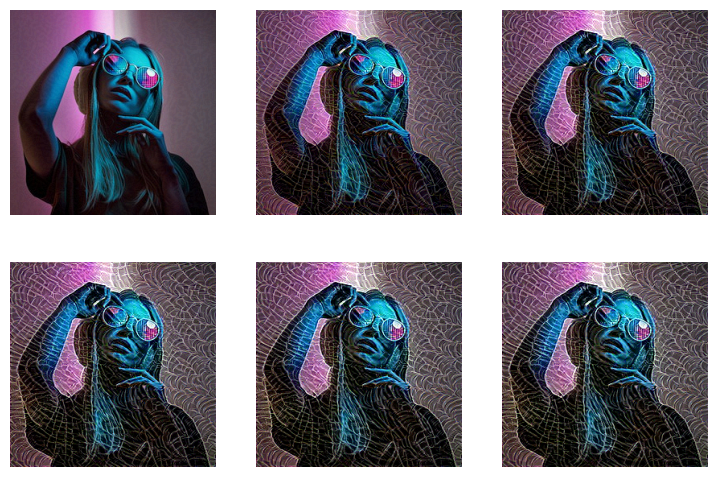

In [ ]:
model = TensorModel(content_im) # Start from content image
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im)
def combined_loss(x):
    return style_loss(x) + content_loss(x)
learn = Learner(model, get_dummy_dls(150), combined_loss, lr=1e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(30)])

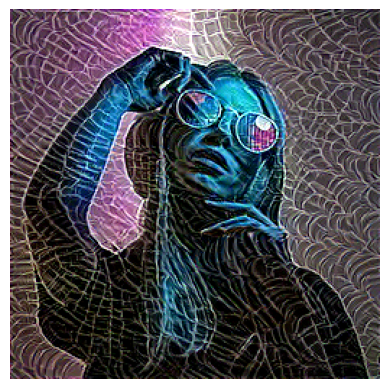

In [ ]:
show_image(learn.model().clip(0, 1));

And trying with random starting image, weighting the style loss lower, using different layers:

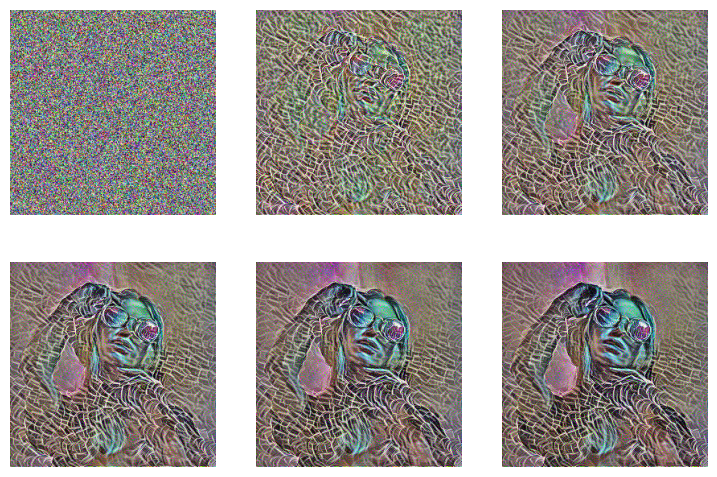

In [ ]:
model = TensorModel(torch.rand_like(content_im))
style_loss = StyleLossToTarget(style_im)
content_loss = ContentLossToTarget(content_im, target_layers=[6, 18, 25])
def combined_loss(x):
    return style_loss(x) * 0.2 + content_loss(x)
learn = Learner(model, get_dummy_dls(300), combined_loss, lr=5e-2, cbs=cbs, opt_func=torch.optim.Adam)
learn.fit(1, cbs=[ImageLogCB(60)])

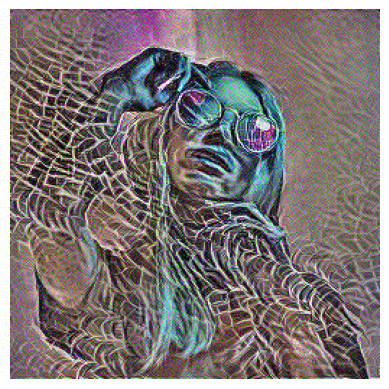

In [ ]:
# Contrast: non-miniai version
im = torch.rand(3, 256, 256).to(def_device)
im.requires_grad = True

opt = torch.optim.Adam([im], lr=5e-2)

for i in range(300):
    loss = combined_loss(im)
    loss.backward()
    opt.step()
    opt.zero_grad()
    
show_image(im.clip(0, 1));